In [1]:
import os
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

from pathlib import Path

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
save_folder = Path("./Plots")
save_folder.mkdir(exist_ok=True)

plt.rcParams.update({
    #"text.usetex": True,
    "font.size": 14,      
    "axes.titlesize": 14,  
    "axes.labelsize": 14, 
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14 
})

### Check previous training results

In [3]:
# Function to check if the hyperparameter combination already exists in CSV
def is_hyperparameter_row_present(hyperparameters, existing_rows):
    hyperparameter_tuple = tuple(sorted({
        key: str(val) for key, val in  hyperparameters.items()
    }.items()))
    return hyperparameter_tuple in existing_rows

In [4]:
csv_file_path = f"svm_training_result.csv"

# Initialize an empty set to store processed hyperparameter combinations
existing_rows = set()

# Check if the CSV file already exists and load existing rows
if os.path.exists(csv_file_path):
    with open(csv_file_path, mode='r', newline='') as f:
        reader = csv.reader(f)
        # Read the headers and rows from the existing file
        headers = next(reader)
        for row in reader:
            # Convert each row back into a dictionary of hyperparameters
            row_dict = dict(zip(headers, row))
            row_dict.pop("test_acc")
            row_dict.pop("train_acc")
            # Create a hashable tuple for checking if the row already exists
            existing_rows.add(tuple(sorted(row_dict.items())))


### Training

In [5]:
binary = True
N_tries = 10
dimensions = [9, 12, 15, 18]#, 24, 30, 45]

#dimension = 9
for dimension in dimensions:
    X = np.load(f"Datasets/kryptonite-{dimension}-X.npy")
    y = np.load(f"Datasets/kryptonite-{dimension}-y.npy")

    if binary:
        X = np.where(X>0.5, 1, 0)

    for i_run in range(N_tries):        
        params = {
            "n": dimension,
            "run": i_run,
        }
        
        # Check if this combination has already been processed
        if is_hyperparameter_row_present(params, existing_rows):
            print(f"Skipping already processed combination: {params}")
            continue  # Skip to the next combination
        print(f"Dim {dimension:02} Run {i_run:02}")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=42)  # 20% test

        model = svm.SVC(gamma=2, C=1)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        #print(f"Run{i:02} Train accuracy: {100*train_accuracy:.03f}%")

        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        #print(f"Run{i:02} Test accuracy: {100*test_accuracy:.03f}%")
        
        # Prepare the result row
        result_row = {"n": dimension, "run": i_run, "test_acc": test_accuracy, "train_acc": train_accuracy}

        # Append the result to the CSV file
        with open(csv_file_path, mode='a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=result_row.keys())
            
            # Write header only if the file is empty (first write)
            if f.tell() == 0:
                writer.writeheader()
            
            writer.writerow(result_row)

Skipping already processed combination: {'n': 9, 'run': 0}
Skipping already processed combination: {'n': 9, 'run': 1}
Skipping already processed combination: {'n': 9, 'run': 2}
Skipping already processed combination: {'n': 9, 'run': 3}
Skipping already processed combination: {'n': 9, 'run': 4}
Skipping already processed combination: {'n': 9, 'run': 5}
Skipping already processed combination: {'n': 9, 'run': 6}
Skipping already processed combination: {'n': 9, 'run': 7}
Skipping already processed combination: {'n': 9, 'run': 8}
Skipping already processed combination: {'n': 9, 'run': 9}
Skipping already processed combination: {'n': 12, 'run': 0}
Skipping already processed combination: {'n': 12, 'run': 1}
Skipping already processed combination: {'n': 12, 'run': 2}
Skipping already processed combination: {'n': 12, 'run': 3}
Skipping already processed combination: {'n': 12, 'run': 4}
Skipping already processed combination: {'n': 12, 'run': 5}
Skipping already processed combination: {'n': 12, 

### Plot results

#### Line plot

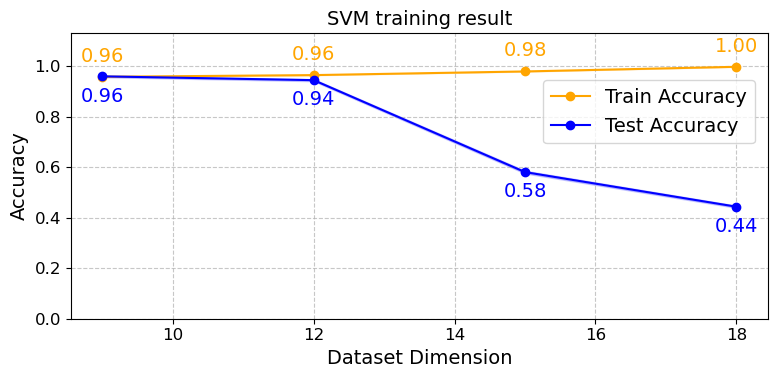

In [6]:
data = pd.read_csv(csv_file_path)

# Group by n and calculate mean and std for test_acc and train_acc
stats = data.groupby('n').agg(
    test_mean=('test_acc', 'mean'),
    test_std=('test_acc', 'std'),
    train_mean=('train_acc', 'mean'),
    train_std=('train_acc', 'std')
).reset_index()

n_values = stats['n'].values
test_mean = stats['test_mean'].values
test_std = stats['test_std'].values
train_mean = stats['train_mean'].values
train_std = stats['train_std'].values

# Create the plot
plt.figure(figsize=(8, 4))

# Plot the train accuracy mean and standard deviation
plt.plot(n_values, train_mean, label='Train Accuracy', color='orange', marker='o', linestyle='-')
plt.fill_between(n_values, train_mean - train_std, train_mean + train_std, color='orange', alpha=0.2)

# Annotate train mean values
for x, y in zip(n_values, train_mean):
    plt.text(x, y + 0.06, f"{y:.2f}", color='orange', fontsize=14, ha='center')
    
# Plot the test accuracy mean and standard deviation
plt.plot(n_values, test_mean, label='Test Accuracy', color='blue', marker='o', linestyle='-')
plt.fill_between(n_values, test_mean - test_std, test_mean + test_std, color='blue', alpha=0.2)

# Annotate test mean values
for x, y in zip(n_values, test_mean):
    plt.text(x, y - 0.1, f"{y:.2f}", color='blue', fontsize=14, ha='center')
    
plt.title('SVM training result', fontsize=14)
plt.xlabel('Dataset Dimension', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.995, 0.87))
plt.grid( linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.13)
plt.tight_layout()

save_filename = save_folder / "svm_training_result.pdf"
plt.savefig(save_filename, bbox_inches='tight', format="pdf")
plt.show()


#### Box plot

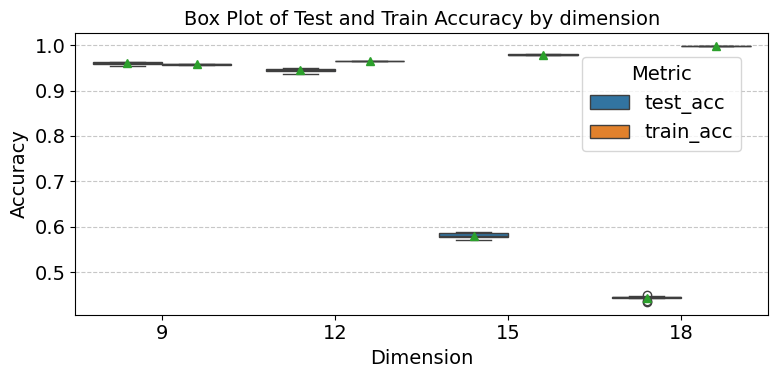

In [7]:
# Melt the data to long format for easier plotting
data_melted = data.melt(id_vars=['n', 'run'], value_vars=['test_acc', 'train_acc'], 
                        var_name='Metric', value_name='Accuracy')

# Create the box plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='n', y='Accuracy', hue='Metric', data=data_melted, showmeans=True)

plt.title('Box Plot of Test and Train Accuracy by dimension')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.legend(title='Metric', loc='upper right', bbox_to_anchor=(0.975, 0.95))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
